This notebook compares the performance of different distributed estimation schemes :<br>
- KCF (Kalman Consensus Filter, 2007)<br>
- OKCF (Optimal KCF, 2017) <br>
- KCF-WDG (KCF with Weighted Consensus, 2019)<br>

In [1]:
import os
import settings.input

# Choose target and sensor-network
input_files = []
input_files.append(os.path.join("settings","json_files", "target-rotating.json"))
input_files.append(os.path.join("settings","json_files", "graph-chain.json"))

# Read input files
input_data = settings.input.read(input_files)

Consider a network of sensors connected as,

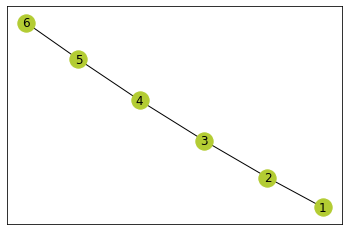

In [2]:
from sim.helpers import graph_plot
graph_plot(input_data["network"]["adjacency"])

Consider the scenario where some sensors have high estimation error (essentially 'naive'). 

We expect this to cause relatively poor performance throughout the network, in the case of distributed estimation schemes that do not weight their neighbors' information (such as the Kalman Consensus Filter).

In the following simulation, the sensor network observes a target in a circular trajectory (in presense of significant system noise). Sensors `4`, `5` and `6` are naive for a part of the simulation. <br>
We compare the performance of KCF, OKCF & KCF-WDG :

In [3]:
from sim.simulation import Simulation
import numpy as np
from sim.helpers import column

initial_estimate = column([[0], [0]])
initial_ErrCov = 100*np.identity(2)
initial_NoiseCov = 100*np.identity(2)
naive_NoiseCov = 100000*np.identity(2)

simulation = Simulation(input_data, est_schemes=["KCF", "OKCF", "KCF-WDG"], duration = 60)

# Initial values
simulation.add_event(iteration=0, attribute="estimate_prior", value=initial_estimate)
simulation.add_event(iteration=0, attribute="ErrCov_prior", value=initial_ErrCov)

# Sensor 4, 5 & 6 become naive from iter. 20-40
simulation.add_event(iteration=0, attribute="NoiseCov", value=initial_NoiseCov)
simulation.add_event(iteration=20, sensors=["4", "5", "6"], attribute="NoiseCov", value=naive_NoiseCov)
simulation.add_event(iteration=40, sensors=["4", "5", "6"], attribute="NoiseCov", value=initial_NoiseCov)

# Averaged over 'n_simulations' simulations
results = simulation.run(n_simulations=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Selected scheme KCF (2009)
Selected scheme Optimal KCF (It's not fully-distributed!)
Selected scheme KCF-WDG (It's not fully-distributed!)




100%|██████████| 2000/2000 [1:25:39<00:00,  2.57s/it]


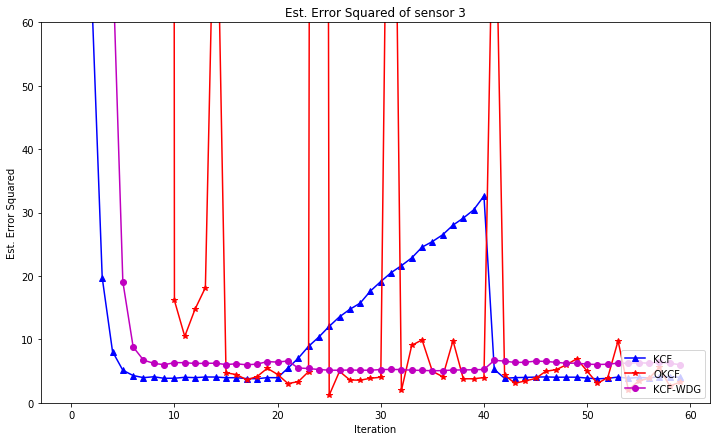

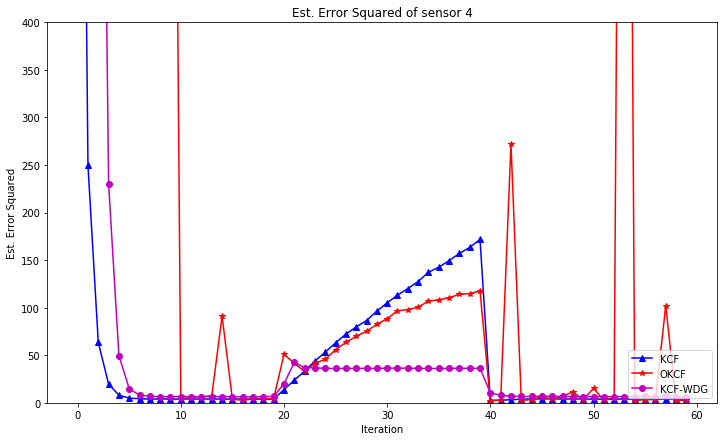

In [4]:
# simulation.plot_xy(sensor="3")
simulation.plot_error_squared(sensor="3", ylim=60.0)
simulation.plot_error_squared(sensor="4", ylim=400.0)

Evidently, the error of KCF and OKCF climbs during the 'naive' period. KCF-WDG has a small bounded increase in error.<br>

I need to look into why the averaged error for OKCF scheme has spikes. Probably related to matrix inversion.